In [81]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import math
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import statsmodels.api as sm

from sklearn.preprocessing import MinMaxScaler
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from keras.layers import ConvLSTM2D

In [82]:
plt.rcParams["figure.figsize"] = (15,4)
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [83]:
data = pd.read_excel(r'POCM_HISTORICAL.xlsx')
df1 = data[["Checkout_Date","Order_Quantity"]]

In [84]:
df1

,Checkout_Date,Order_Quantity
0,2018-12-04,1
1,2018-12-04,1
2,2018-12-05,5
3,2018-12-05,10
4,2018-12-05,20
...,...,...
160572,2020-05-15,5
160573,2020-05-15,20
160574,2020-05-15,2
160575,2020-05-15,3


In [85]:
df = df1.groupby(["Checkout_Date"])['Order_Quantity'].sum().reset_index()
df.tail()

,Checkout_Date,Order_Quantity
465,2020-05-11,2749
466,2020-05-12,3366
467,2020-05-13,1491
468,2020-05-14,6631
469,2020-05-15,1018


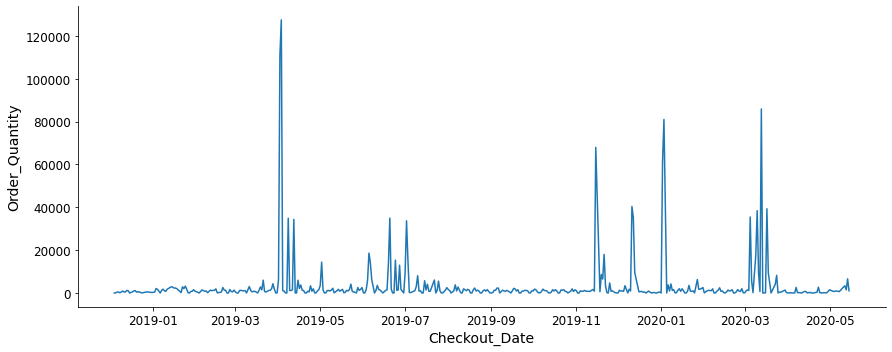

In [125]:
sns.relplot(x = 'Checkout_Date', y = 'Order_Quantity', data = df, kind = 'line', height = 5, aspect = 2.5)

In [87]:
#Stationarity checking

from statsmodels.tsa.stattools import adfuller
#Ho: It is non stationary
#H1: It is stationary

def adf_test(Order_Quantity):
    result=adfuller(Order_Quantity)
    labels = ['ADF stats','p-value','#Lags Used','Num of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("The test rejects the null hypothesis and is stationary")
    else:
        print("The test validates the null hypothesis and is non-stationary ")

adf_test(df['Order_Quantity'])

ADF stats : -10.147197874904466
p-value : 8.127120756465757e-18
#Lags Used : 2
Num of Observations : 467
The test rejects the null hypothesis and is stationary


In [88]:
from statsmodels.tsa.seasonal import seasonal_decompose
#Additive decomposition
add_result = seasonal_decompose(df['Order_Quantity'],model='additive',freq = 52) # annual=1,Quaterly=4,monthly=12,weekly=52

#Multiplicative decompostion
mul_result = seasonal_decompose(df['Order_Quantity'], model='multiplicative',freq=52)

Text(0.5, 0.98, '\nMultiplicative Decompose')

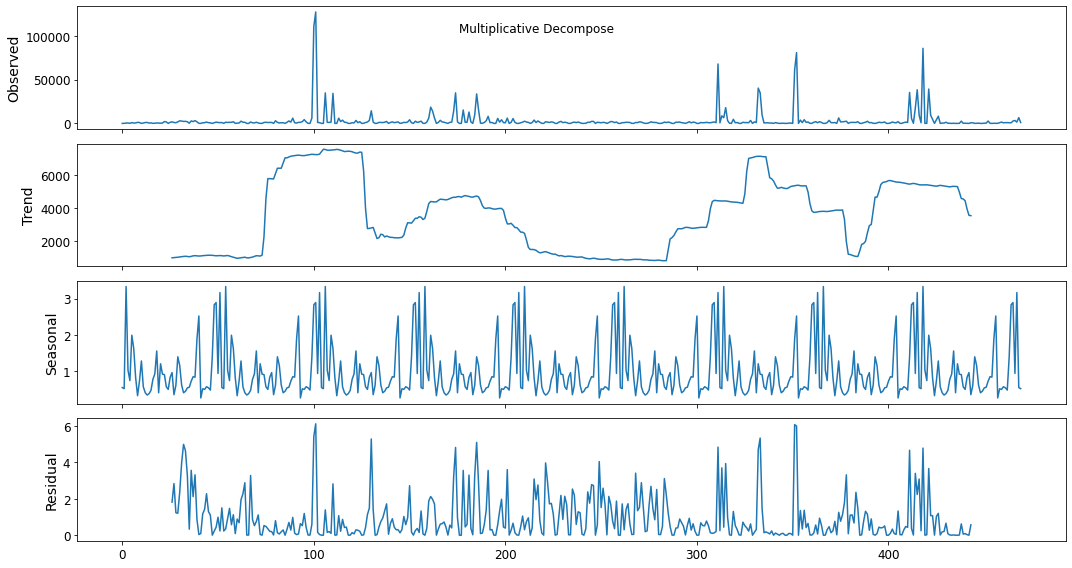

In [89]:
# Plot
plt.rcParams.update({'figure.figsize': (15,8)})
mul_result.plot().suptitle('\nMultiplicative Decompose', fontsize=12)

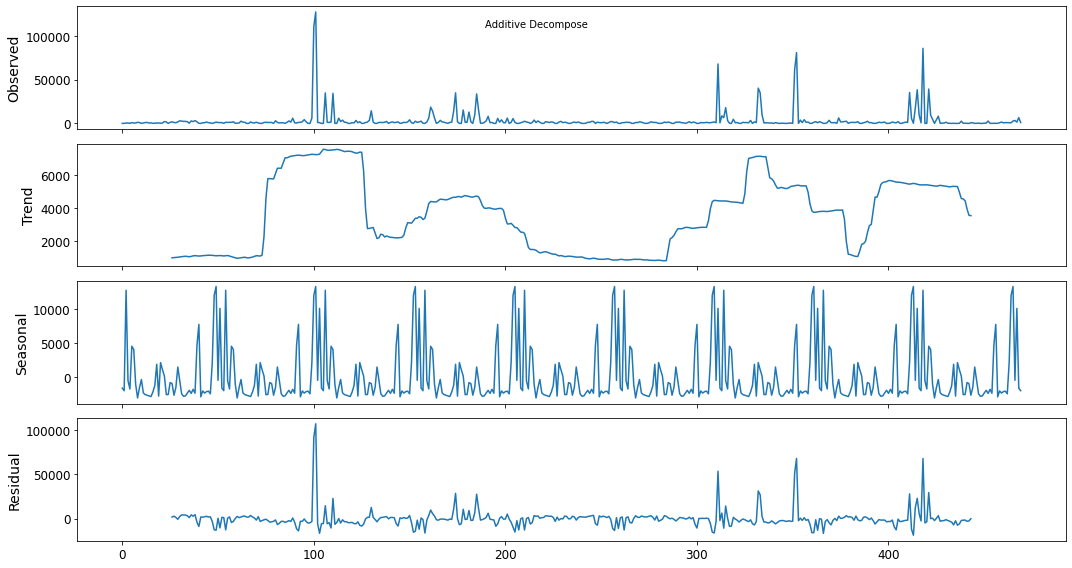

In [123]:
add_result.plot().suptitle('\nAdditive Decompose', fontsize=10)
plt.show()

In [91]:
#Additive
new_df_add = pd.concat([add_result.seasonal, add_result.trend, add_result.resid, add_result.observed], axis=1)
new_df_add.columns = ['seasoanilty', 'trend', 'residual', 'actual_values']
new_df_add.head(5)

,seasoanilty,trend,residual,actual_values
0,-1669.239861,NaN,NaN,2
1,-2052.713418,NaN,NaN,79
2,12828.157976,NaN,NaN,422
3,-567.880486,NaN,NaN,468
4,-1794.624476,NaN,NaN,111


In [92]:
#Multiplicative
new_df_mult = pd.concat([mul_result.seasonal, mul_result.trend, mul_result.resid, mul_result.observed], axis=1)
new_df_mult.columns = ['seasoanilty', 'trend', 'residual', 'actual_values']
new_df_mult.head(5)

,seasoanilty,trend,residual,actual_values
0,0.556888,NaN,NaN,2
1,0.527839,NaN,NaN,79
2,3.329785,NaN,NaN,422
3,1.034855,NaN,NaN,468
4,0.748085,NaN,NaN,111


In [93]:
len(df)

470

In [94]:
#The next step is to split the data into training and test sets

#selecting a time specific data, we can consider it as our train data 
daily1 = df.loc[df['Checkout_Date'].between('2018-12-04','2020-04-30', inclusive=True)].set_index('Checkout_Date')

#we can consider it as test data after training and getting prediction of the previous data.
daily2 = df.loc[df['Checkout_Date'].between('2020-05-01','2020-05-15', inclusive=True)].set_index('Checkout_Date')


In [95]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(daily1)
scaled_train= scaler.transform(daily1)
scaled_test= scaler.transform(daily2)
scaled_train[:5]

array([[7.84972487e-06],
       [6.12278540e-04],
       [3.30473417e-03],
       [3.66582151e-03],
       [8.63469735e-04]])

In [97]:
from keras.preprocessing.sequence import TimeseriesGenerator

#define generator
n_input = 3
n_features= 1
generator = TimeseriesGenerator(scaled_train,scaled_train, length=n_input, batch_size=1)

In [98]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n{y}')

Given the Array: 
[7.84972487e-06 6.12278540e-04 3.30473417e-03]
Predict this y: 
[[0.00366582]]


In [99]:
X.shape

(1, 3, 1)

In [100]:
# now taking input or step size as 20

n_input = 20
generator = TimeseriesGenerator(scaled_train,scaled_train, length=n_input, batch_size=1)

In [101]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Flatten

#defining model
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 200)               161600    
                                                                 
 dense_1 (Dense)             (None, 1)                 201       
                                                                 
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [102]:
model.fit_generator(generator,epochs=200)

Epoch 1/200
439/439 [==============================] - 8s 16ms/step - loss: 0.0086
Epoch 2/200
439/439 [==============================] - 7s 16ms/step - loss: 0.0084
Epoch 3/200
439/439 [==============================] - 7s 16ms/step - loss: 0.0082
Epoch 4/200
439/439 [==============================] - 7s 16ms/step - loss: 0.0083
Epoch 5/200
439/439 [==============================] - 7s 16ms/step - loss: 0.0078
Epoch 6/200
439/439 [==============================] - 7s 15ms/step - loss: 0.0076
Epoch 7/200
439/439 [==============================] - 7s 16ms/step - loss: 0.0075
Epoch 8/200
439/439 [==============================] - 7s 15ms/step - loss: 0.0073
Epoch 9/200
439/439 [==============================] - 8s 18ms/step - loss: 0.0073
Epoch 10/200
439/439 [==============================] - 8s 17ms/step - loss: 0.0071
Epoch 11/200
439/439 [==============================] - 7s 15ms/step - loss: 0.0070
Epoch 12/200
439/439 [==============================] - 7s 16ms/step - loss: 0.0071
E

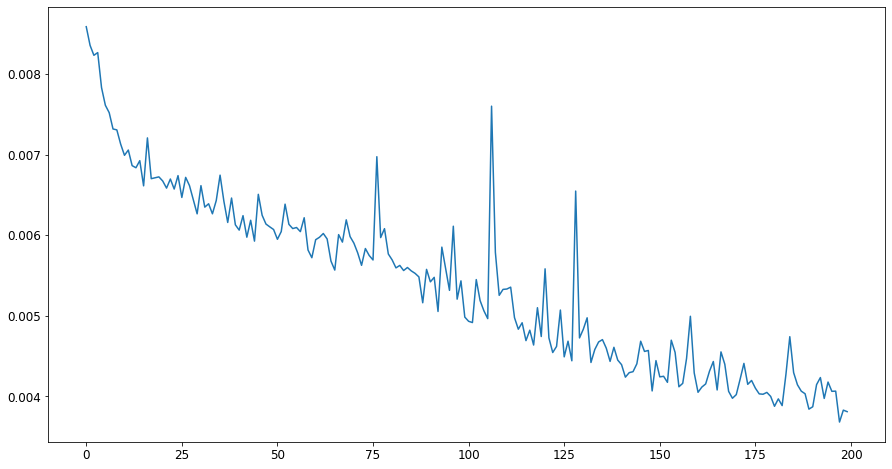

In [104]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [105]:
last_train_batch = scaled_train[-20:]

In [106]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [107]:
model.predict(last_train_batch)

array([[0.01645548]], dtype=float32)

In [110]:
scaled_test[0]     #We got value almost close to the orginal value 

array([0.01179029])

In [111]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(daily2)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [112]:
test_predictions

[array([0.01645548], dtype=float32),
 array([0.01905567], dtype=float32),
 array([0.0193505], dtype=float32),
 array([0.01914279], dtype=float32),
 array([0.01835018], dtype=float32),
 array([0.01875078], dtype=float32),
 array([0.01809148], dtype=float32),
 array([0.01403989], dtype=float32),
 array([0.01035471], dtype=float32),
 array([0.01053466], dtype=float32),
 array([0.01131531], dtype=float32)]

In [113]:
true_predictions = scaler.inverse_transform(test_predictions)

In [114]:
daily2['Predictions'] = true_predictions

In [122]:
daily2.tail()

,Order_Quantity,Predictions
Checkout_Date,,
2020-05-11,2749,2305.728299
2020-05-12,3366,1789.584051
2020-05-13,1491,1320.117903
2020-05-14,6631,1343.041580
2020-05-15,1018,1442.491334


In [118]:
print(daily2.Order_Quantity.mean())
print(daily2.Predictions.mean())

1882.5454545454545
2032.8194330564954


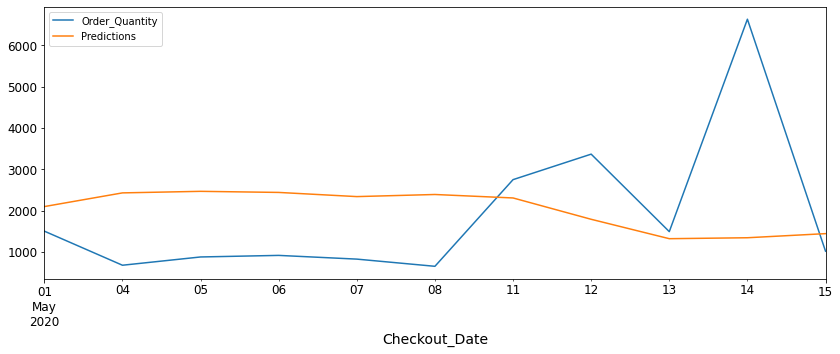

In [119]:
daily2.plot(figsize = (14,5))

In [120]:
# Checking Evaluation/Performance Metrics

lstm_rmse_error = rmse(daily2['Order_Quantity'], daily2["Predictions"])
lstm_mse_error = lstm_rmse_error**2

print(f'MSE Error: {lstm_mse_error}\nRMSE Error: {lstm_rmse_error}')

MSE Error: 4038424.572664323
RMSE Error: 2009.5831838130819
